In [183]:
import pickle
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
from cmocean.cm import balance_r, haline, thermal
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import heatmap, PairGrid, kdeplot, distplot
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [196]:
display(HTML("<style>.container {width:95% !important}</style>"))

In [104]:
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16

In [3]:
% matplotlib inline

In [4]:
with open('./Dataset/aurin_v1.pkl', 'rb') as fb:
    dataset = pickle.load(fb)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51192 entries, 0 to 51191
Data columns (total 16 columns):
sample_id    51192 non-null int32
year         51192 non-null uint16
month        51192 non-null uint8
day          51192 non-null uint8
hr           51192 non-null uint8
min          51192 non-null uint8
lat          51192 non-null float64
lon          51192 non-null float64
bdepth       51086 non-null float64
depth        51188 non-null float64
Wt           47432 non-null float64
Sal          47542 non-null float64
ag412        48378 non-null float64
S275:295     2480 non-null float64
DOC          1957 non-null float64
POC          625 non-null float64
dtypes: float64(10), int32(1), uint16(1), uint8(4)
memory usage: 4.8 MB


In [6]:
df_novak = pd.read_pickle('./Dataset/novak_v1.pkl')

In [7]:
df_novak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 1 to 1325
Data columns (total 17 columns):
sample_id    1325 non-null object
year         1325 non-null object
month        1325 non-null object
day          1325 non-null object
hr           1325 non-null object
min          1325 non-null object
lat          1325 non-null object
lon          1325 non-null object
bdepth       1224 non-null object
depth        1135 non-null object
Wt           816 non-null object
Sal          997 non-null object
ag412        1207 non-null object
S275:295     1208 non-null object
DOC          1258 non-null object
POC1         1321 non-null object
POC2         1321 non-null object
dtypes: object(17)
memory usage: 176.1+ KB


In [8]:
df_novak.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 1 to 1046
Data columns (total 17 columns):
sample_id    749 non-null object
year         749 non-null object
month        749 non-null object
day          749 non-null object
hr           749 non-null object
min          749 non-null object
lat          749 non-null object
lon          749 non-null object
bdepth       749 non-null object
depth        749 non-null object
Wt           749 non-null object
Sal          749 non-null object
ag412        749 non-null object
S275:295     749 non-null object
DOC          749 non-null object
POC1         749 non-null object
POC2         749 non-null object
dtypes: object(17)
memory usage: 105.3+ KB


In [9]:
df_merged = pd.read_pickle('./Dataset/novak_aurin_merged_v1.pkl')

In [10]:
df_merged.rename(columns=dict(min='mn'), inplace=True)

In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52517 entries, 1 to 51191
Data columns (total 14 columns):
year        52517 non-null object
month       52517 non-null object
day         52517 non-null object
hr          52517 non-null object
mn          52517 non-null object
lat         52517 non-null object
lon         52517 non-null object
bdepth      52310 non-null object
depth       52323 non-null object
Wt          48248 non-null object
Sal         48539 non-null object
ag412       49585 non-null object
S275:295    3688 non-null object
DOC         3215 non-null object
dtypes: object(14)
memory usage: 6.0+ MB


In [12]:
df_merged.loc[:, :'mn'] = df_merged.loc[:, :'mn'].astype('str')

In [13]:
df_merged.insert(0, 'time', df_merged.hr + ':' + df_merged.mn + ':00')
df_merged.insert(0, 'date', df_merged.day + '-' + df_merged.month + '-' + df_merged.year)

In [23]:
df_merged_clean = df_merged.dropna().copy()

In [24]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 1 to 3182
Data columns (total 16 columns):
date        1146 non-null object
time        1146 non-null object
year        1146 non-null object
month       1146 non-null object
day         1146 non-null object
hr          1146 non-null object
mn          1146 non-null object
lat         1146 non-null object
lon         1146 non-null object
bdepth      1146 non-null object
depth       1146 non-null object
Wt          1146 non-null object
Sal         1146 non-null object
ag412       1146 non-null object
S275:295    1146 non-null object
DOC         1146 non-null object
dtypes: object(16)
memory usage: 152.2+ KB


In [25]:
df_merged_clean.date=pd.to_datetime(df_merged_clean.date,
                                    format='%d-%m-%Y')

In [26]:
df_merged_clean.drop(['time', 'year', 'month', 'day', 'hr', 'mn'], 
                    axis=1, inplace=True)

In [27]:
df_merged_clean.loc[:, 'lat':] = df_merged_clean.loc[:, 'lat':].astype('f8')

In [28]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 1 to 3182
Data columns (total 10 columns):
date        1146 non-null datetime64[ns]
lat         1146 non-null float64
lon         1146 non-null float64
bdepth      1146 non-null float64
depth       1146 non-null float64
Wt          1146 non-null float64
Sal         1146 non-null float64
ag412       1146 non-null float64
S275:295    1146 non-null float64
DOC         1146 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 98.5 KB


In [29]:
df_merged_clean.to_pickle('./Dataset/df_merged_clean.pkl')

In [32]:
df_merged_clean.date.dt.month.value_counts()

6     293
8     278
11    254
5     140
2      75
7      60
3      18
1      13
4       6
9       5
10      4
Name: date, dtype: int64

In [33]:
df_ms = df_merged_clean.loc[:, 'lat':]

In [34]:
df_ms.corr()

,lat,lon,bdepth,depth,Wt,Sal,ag412,S275:295,DOC
lat,1.000000,-0.658293,-0.835743,0.078590,-0.045708,-0.154797,0.218019,-0.460882,0.187867
lon,-0.658293,1.000000,0.543981,-0.001978,-0.101355,0.161646,-0.201686,0.305139,-0.242111
bdepth,-0.835743,0.543981,1.000000,0.010692,0.064702,0.258251,-0.302565,0.523498,-0.300796
depth,0.078590,-0.001978,0.010692,1.000000,-0.274197,0.262514,-0.221960,0.044454,-0.377358
Wt,-0.045708,-0.101355,0.064702,-0.274197,1.000000,-0.172628,0.031742,0.265842,0.406752
Sal,-0.154797,0.161646,0.258251,0.262514,-0.172628,1.000000,-0.609227,0.407302,-0.666214
ag412,0.218019,-0.201686,-0.302565,-0.221960,0.031742,-0.609227,1.000000,-0.670775,0.739398
S275:295,-0.460882,0.305139,0.523498,0.044454,0.265842,0.407302,-0.670775,1.000000,-0.447289
DOC,0.187867,-0.242111,-0.300796,-0.377358,0.406752,-0.666214,0.739398,-0.447289,1.000000


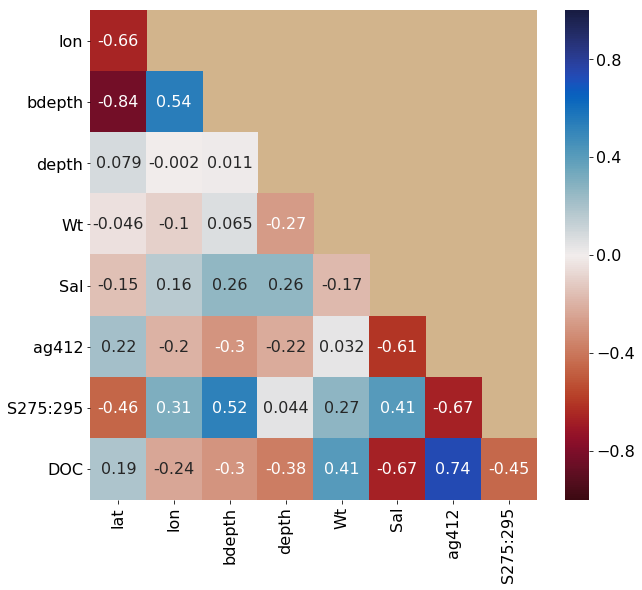

In [106]:
f, ax = pl.subplots(figsize=(10, 9))
heatmap(df_ms.corr().iloc[1:, :-1], vmin=-1, vmax=1, ax=ax,
       annot=True, cmap=balance_r, mask=np.triu(np.ones([df_ms.shape[1]-1]*2), k=1))
ax.set_facecolor('tan')
f.savefig('./FigJar/corr_heatmap.pdf', dpi=300, format='pdf')

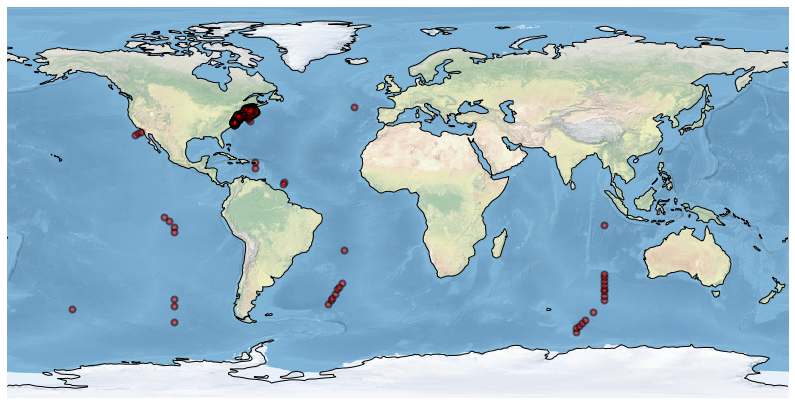

In [107]:
subplot_kw = dict(projection=ccrs.PlateCarree())
f, ax = pl.subplots(figsize=(14, 8),
                   subplot_kw=subplot_kw)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.stock_img()
ax.coastlines()
ax.scatter(df_merged_clean.lon, df_merged_clean.lat,
           color='red', edgecolor='k', alpha=0.5, lw=2)
f.savefig('./FigJar/map.pdf', dpi=300, format='pdf')

In [37]:
df_merged_clean.lon.describe()

count    1146.000000
mean      -68.974345
std        19.562577
min      -149.997000
25%       -73.901203
50%       -70.567285
75%       -68.225587
max        95.006200
Name: lon, dtype: float64

In [98]:
min_lat, max_lat, min_lon, max_lon = 32, 47, -81.5, -59
df_m_c_mab = df_merged_clean.loc[((df_merged_clean.lat<=max_lat) & 
                                  (df_merged_clean.lat>=min_lat) &
                                  (df_merged_clean.lon>=min_lon) &
                                  (df_merged_clean.lon<=max_lon))]

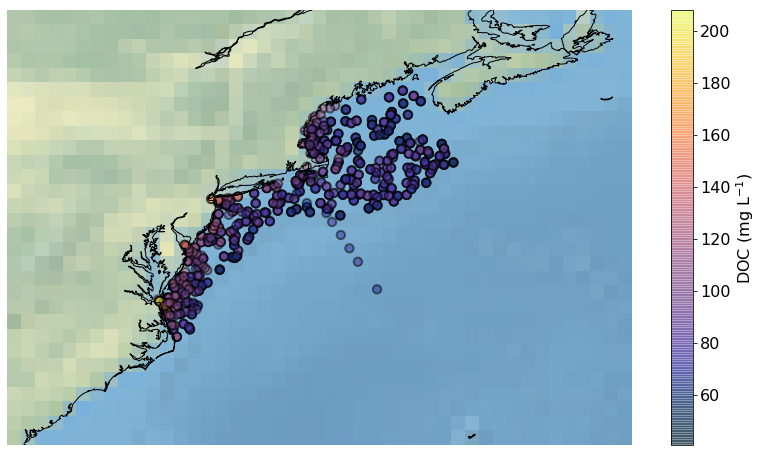

In [109]:
extent = [min_lon, max_lon, min_lat, max_lat]
subplot_kw = dict(projection=ccrs.PlateCarree())
f, ax = pl.subplots(subplot_kw=subplot_kw, figsize=(14, 8))
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.background_img(extent=extent)
ax.coastlines(resolution='10m')
scat = ax.scatter(df_m_c_mab.lon, df_m_c_mab.lat, cmap=thermal,
           vmin=df_m_c_mab.DOC.min(), vmax=df_m_c_mab.DOC.max(),
           c=df_m_c_mab.DOC, #c='k',
           edgecolor='k', s=70, alpha=0.5, lw=2)
cax = pl.colorbar(scat, ax=ax,)
cax.set_label(r'DOC (mg L$^{-1}$)')
ax.set_aspect('auto')
ax.set_extent(extent, crs=ccrs.PlateCarree())
f.savefig('./FigJar/mab_map.pdf', dpi=300, format='pdf')

In [137]:
df_m_c_mab.describe().T

,count,mean,std,min,25%,50%,75%,max
month,1107.0,7.310750,2.508413,2.000000e+00,6.000000,7.000000,8.000000,11.000000
lat,1107.0,40.393486,2.058549,3.574517e+01,39.016300,40.639550,42.060435,44.233183
lon,1107.0,-71.079657,3.076416,-7.606900e+01,-73.900077,-70.591100,-68.364702,-65.436767
bdepth,1107.0,119.624078,270.204699,2.000000e+00,31.333334,67.800000,139.000000,4750.000000
depth,1107.0,19.825190,46.263401,0.000000e+00,2.030000,3.000000,20.685000,551.130000
Wt,1107.0,13.829580,5.555992,1.000000e-10,10.139983,13.100000,16.519400,28.357000
Sal,1107.0,31.903615,2.421132,4.980300e-01,31.441000,32.259100,32.757050,36.724800
ag412,1107.0,0.163062,0.095890,0.000000e+00,0.109004,0.140464,0.189110,0.873652
S275:295,1107.0,0.025558,0.003337,0.000000e+00,0.023872,0.025533,0.027123,0.041245
DOC,1107.0,88.744993,20.107627,4.062918e+01,76.000000,84.681077,97.780791,207.950000


In [ ]:
df_m_c_mab.insert(1, 'month', df_m_c_mab.date.dt.month)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


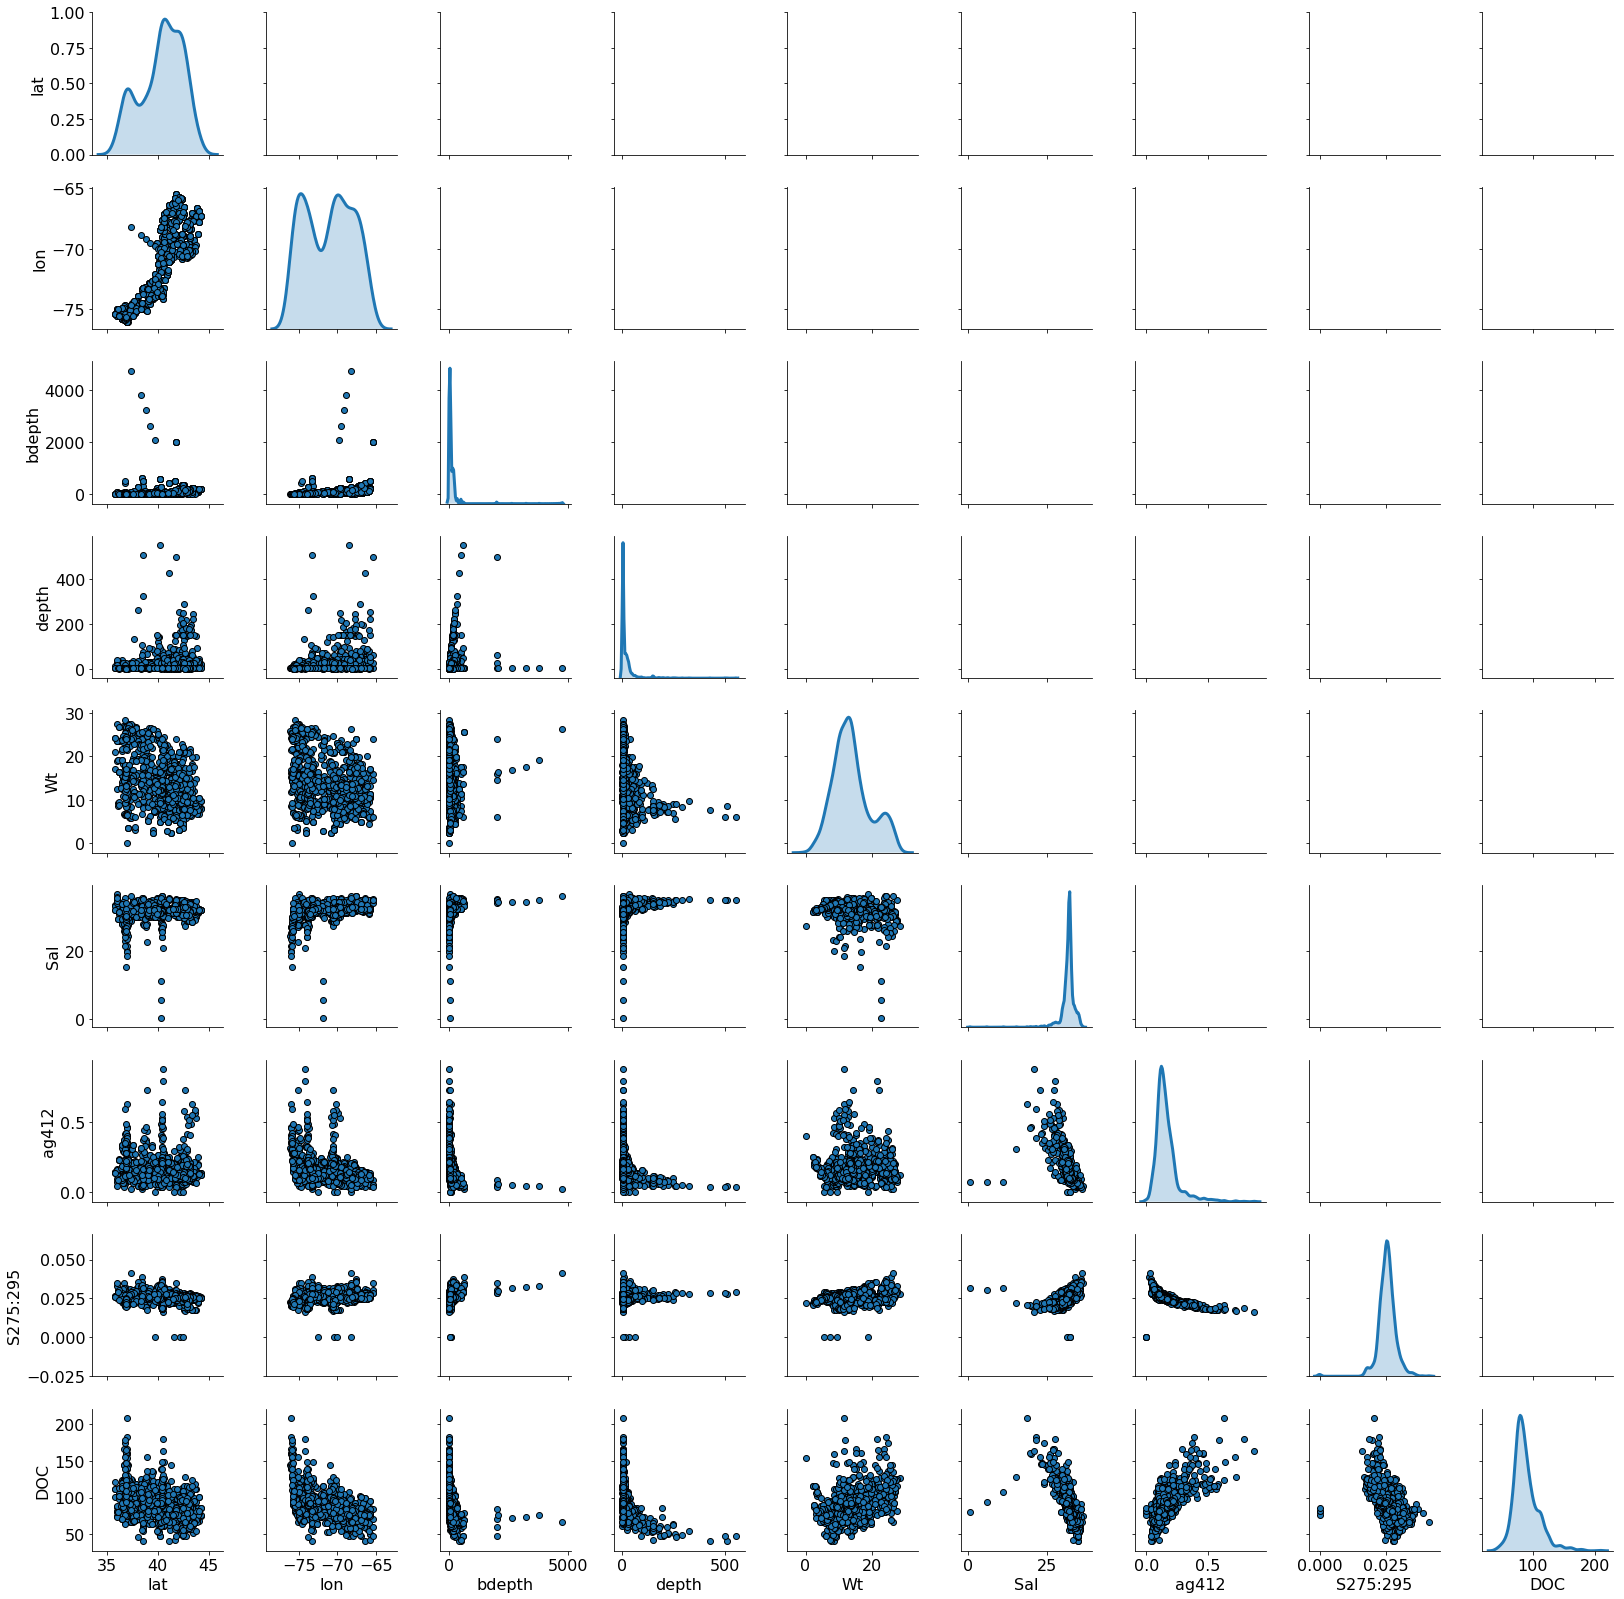

In [132]:
g = PairGrid(df_m_c_mab.loc[:,'lat':], diag_sharey=False)
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k')

### Transformation:

* log-transform depth bdepth, 
* standardize the rest

In [147]:
df_m_c_mab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1107 entries, 1 to 3182
Data columns (total 11 columns):
date        1107 non-null datetime64[ns]
month       1107 non-null int64
lat         1107 non-null float64
lon         1107 non-null float64
bdepth      1107 non-null float64
depth       1107 non-null float64
Wt          1107 non-null float64
Sal         1107 non-null float64
ag412       1107 non-null float64
S275:295    1107 non-null float64
DOC         1107 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 143.8 KB


In [155]:
df_m_c_mab2 = df_m_c_mab.copy()

In [156]:
df_m_c_mab2.depth = np.log10(df_m_c_mab2.depth+1e-6)

In [157]:
df_m_c_mab2.bdepth = np.log10(df_m_c_mab2.bdepth+1e-6)

In [159]:
df_m_c_mab2.rename(columns=dict(depth='log_dep', bdepth='lob_bat_dep'), inplace=True)

In [160]:
df_m_c_mab2.head().T

,1,2,3,4,5
date,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-17 00:00:00,2009-08-18 00:00:00
month,8,8,8,8,8
lat,41.314,41.314,41.314,41.314,40.304
lon,-70.9444,-70.9444,-70.9444,-70.9444,-71.8109
lob_bat_dep,1.53148,1.53148,1.53148,1.53148,1.86332
log_dep,0.155337,0.646404,1.1313,1.45682,0.0899058
Wt,21.0591,20.9185,18.9376,13.9983,22.7161
Sal,31.3975,31.396,31.4249,32.1005,0.49803
ag412,0.17225,0.184552,0.200528,0.182454,0.0745892
S275:295,0.0250035,0.0241851,0.0234506,0.0236282,0.0318233


In [161]:
x_train, x_test, y_train, y_test = train_test_split(df_m_c_mab2.loc[:, :'S275:295'],
                                                    df_m_c_mab2[['DOC']],
                                                   test_size=0.1, random_state=42)

In [162]:
x_train.head().T

,27,489,714,784,360
date,2009-08-20 00:00:00,2010-06-09 00:00:00,2011-06-09 00:00:00,2011-06-15 00:00:00,2010-05-29 00:00:00
month,8,6,6,6,5
lat,37.8549,43.0205,40.6417,42.444,36.8123
lon,-74.6421,-70.0992,-68.3058,-68.8957,-75.3733
lob_bat_dep,1.68124,2.11528,1.89949,2.33616,1.38021
log_dep,0.238047,-0.0315161,1.41044,0.436163,0.920645
Wt,26.4025,14.97,8.3721,12.7135,17.31
Sal,31.1377,30.789,32.4932,31.6277,31.556
ag412,0.0999449,0.184399,0.119291,0.113195,0.117855
S275:295,0.0307217,0.0247006,0.0267603,0.027079,0.0278858


In [165]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((996, 10), (111, 10), (996, 1), (111, 1))

#### Stash test set

In [182]:
with open('./PickleJar/mab_test_dict.pkl', 'wb') as ftest:
    ftest_dict = dict(x_test=x_test, y_test=y_test)
    pickle.dump(ftest_dict, ftest, protocol=pickle.HIGHEST_PROTOCOL)

In [170]:
cols_to_standardize=['lat', 'lon', 'Wt', 'Sal', 'ag412', 'S275:295']
sc=StandardScaler()
sc.fit(x_train[cols_to_standardize])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [175]:
x_train_s = x_train.copy()

In [176]:
x_train_s[cols_to_standardize] = sc.fit_transform(x_train[cols_to_standardize])

In [177]:
x_train_s.describe().T

,count,mean,std,min,25%,50%,75%,max
month,996.0,7.346386e+00,2.521365,2.000000,6.000000,7.000000,8.000000,11.000000
lat,996.0,3.088560e-15,1.000502,-2.270243,-0.649741,0.121174,0.816032,1.877864
lon,996.0,2.111012e-15,1.000502,-1.625183,-0.917695,0.164256,0.883445,1.836439
lob_bat_dep,996.0,1.827100e+00,0.431985,0.301030,1.496007,1.837903,2.146128,3.676694
log_dep,996.0,6.566718e-01,1.150036,-5.698970,0.307496,0.477122,1.316599,2.741254
Wt,996.0,2.476266e-16,1.000502,-2.489845,-0.661296,-0.133735,0.484194,2.610324
Sal,996.0,-8.892931e-16,1.000502,-12.580903,-0.180477,0.143050,0.357366,1.931207
ag412,996.0,3.170155e-16,1.000502,-1.701828,-0.563701,-0.234325,0.274454,7.449722
S275:295,996.0,7.664552e-16,1.000502,-7.561016,-0.503135,-0.007570,0.467153,4.640982


In [179]:
x_train_s.head().T

,27,489,714,784,360
date,2009-08-20 00:00:00,2010-06-09 00:00:00,2011-06-09 00:00:00,2011-06-15 00:00:00,2010-05-29 00:00:00
month,8,6,6,6,5
lat,-1.23923,1.28522,0.122679,1.00349,-1.74875
lon,-1.16061,0.318458,0.902341,0.710299,-1.39867
lob_bat_dep,1.68124,2.11528,1.89949,2.33616,1.38021
log_dep,0.238047,-0.0315161,1.41044,0.436163,0.920645
Wt,2.25879,0.202596,-0.984074,-0.203249,0.623458
Sal,-0.30695,-0.44662,0.236067,-0.110644,-0.139367
ag412,-0.6549,0.229762,-0.452247,-0.516109,-0.46729
S275:295,1.52784,-0.253481,0.355871,0.45015,0.688851


#### Pickle original and standardized training sets, along with parameterized standardscaler and list of column labels to standardize

In [181]:
with open('./PickleJar/mab_train_dict.pkl', 'wb') as f_train:
    f_train_dict = dict(original_x = x_train,
                       stdized_x = x_train_s,
                       y=y_train, scaler=sc, col_label_list=cols_to_standardize)
    pickle.dump(f_train_dict, f_train, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
x_train_s.insert(1, 'month_name', x_train_s.date.dt.month_name())

In [190]:
x_train_s.insert(1, 'year', x_train_s.date.dt.year)
x_train_s.month_name.value_counts()

June         255
August       250
November     234
May          124
February      60
July          55
March          9
September      5
April          4
Name: month_name, dtype: int64

In [191]:
x_train_s.year.value_counts()

2010    318
2009    222
2011    147
2012    140
2006     58
2007     54
2005     47
2003      6
2008      4
Name: year, dtype: int64

In [192]:
months_ = [month for month in x_train_s.month_name.unique()]
years_ = [year for year in x_train_s.year.unique()]

In [193]:
months_, years_

(['August',
  'June',
  'May',
  'November',
  'July',
  'February',
  'March',
  'April',
  'September'],
 [2009, 2010, 2011, 2012, 2006, 2005, 2007, 2003, 2008])

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83

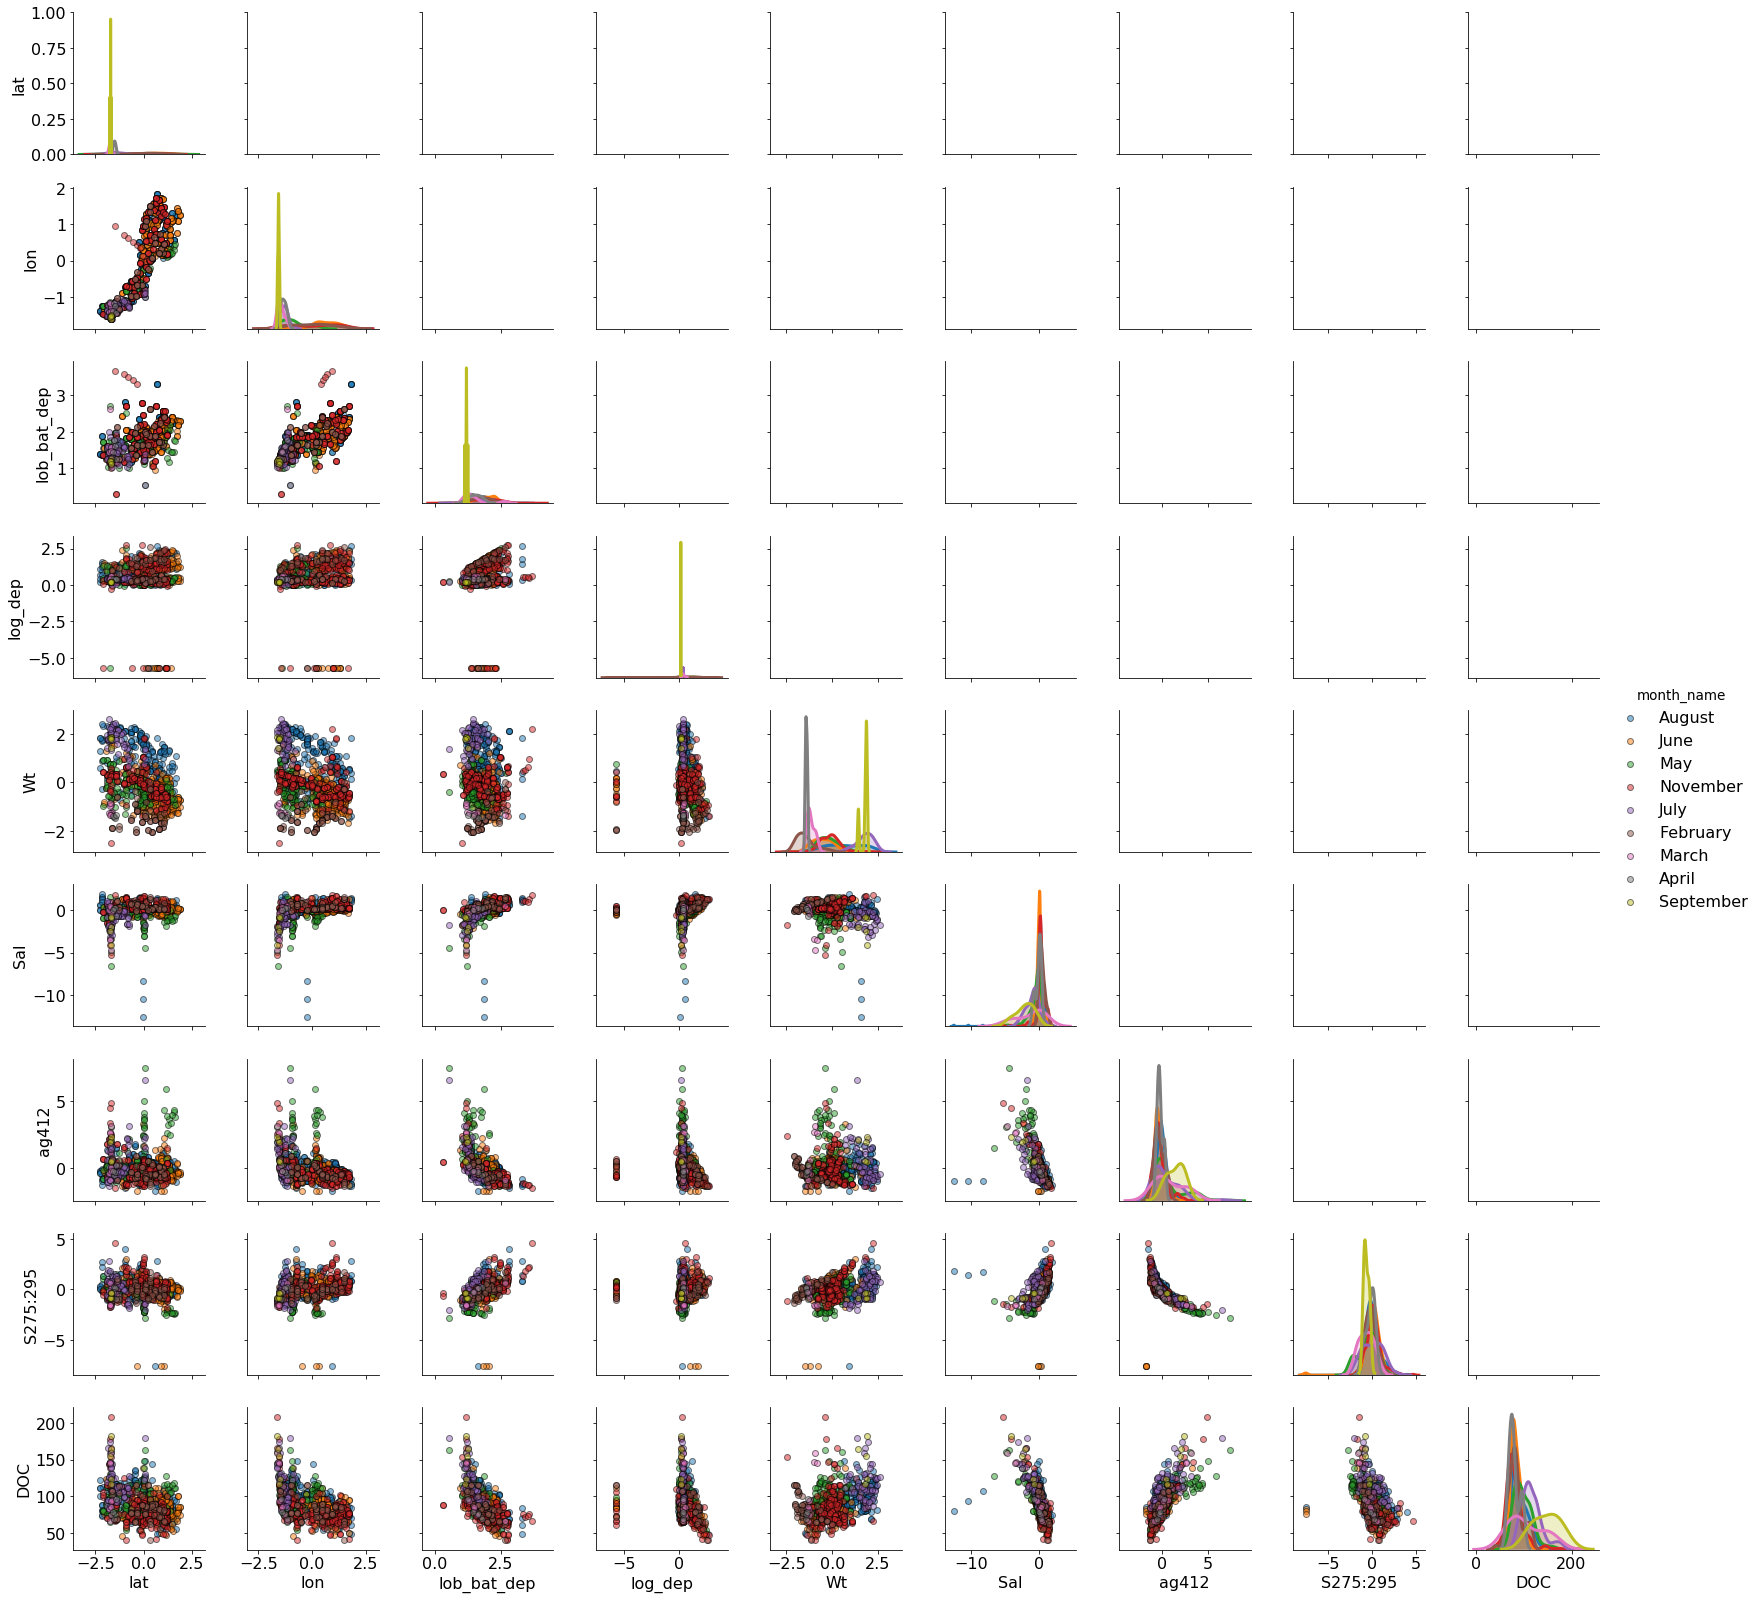

In [199]:
g = PairGrid(pd.concat((x_train_s, y_train), axis=1, ), diag_sharey=False, hue='month_name',
             vars=['lat', 'lon', 'lob_bat_dep', 'log_dep', 'Wt', 'Sal',
                  'ag412', 'S275:295', 'DOC'])
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k', alpha=0.5)
g.add_legend()

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


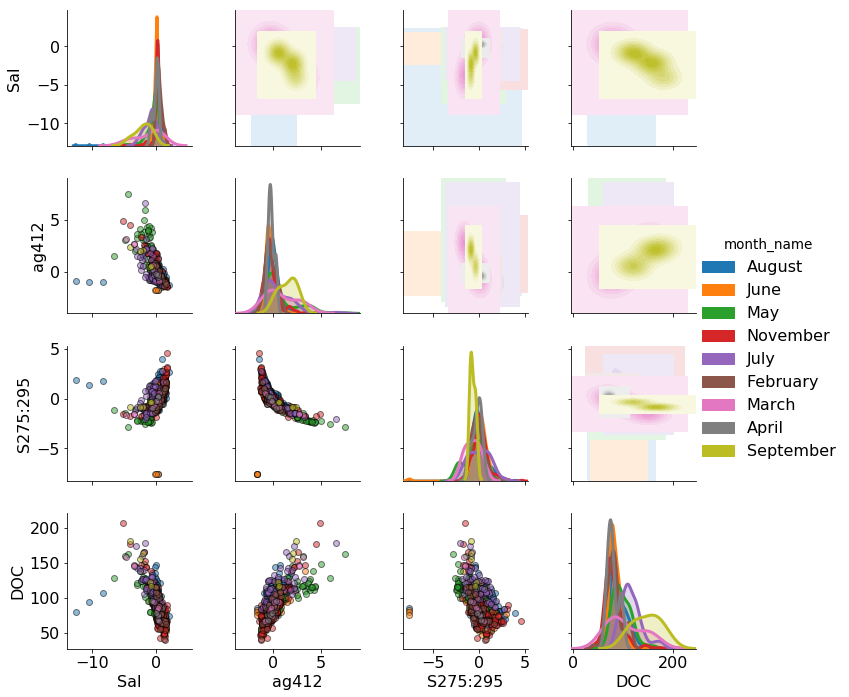

In [202]:
g = PairGrid(pd.concat((x_train_s, y_train), axis=1, ), diag_sharey=False, hue='month_name',
             vars=[ 'Sal', 'ag412', 'S275:295', 'DOC'])
g.map_diag(kdeplot, lw=3, shade=True)
g.map_lower(pl.scatter, edgecolor='k', alpha=0.5)
g.add_legend()